In [ ]:
!pip3 install tensorflow pandas numpy matplotlib yahoo_fin sklearn seaborn openpyxl ccxt ta-lib ta 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

import talib as ta
from talib import MACD

2022-03-16 09:39:19.721597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-16 09:39:19.721619: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import os
from pathlib import Path

import sys
import csv

# -----------------------------------------------------------------------------

root = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(''))))
sys.path.append(root + '/python')

import ccxt


# -----------------------------------------------------------------------------

def retry_fetch_ohlcv(exchange, max_retries, symbol, timeframe, since, limit):
    num_retries = 0
    try:
        num_retries += 1
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        # print('Fetched', len(ohlcv), symbol, 'candles from', exchange.iso8601 (ohlcv[0][0]), 'to', exchange.iso8601 (ohlcv[-1][0]))
        return ohlcv
    except Exception:
        if num_retries > max_retries:
            raise  # Exception('Failed to fetch', timeframe, symbol, 'OHLCV in', max_retries, 'attempts')


def scrape_ohlcv(exchange, max_retries, symbol, timeframe, since, limit):
    earliest_timestamp = exchange.milliseconds()
    timeframe_duration_in_seconds = exchange.parse_timeframe(timeframe)
    timeframe_duration_in_ms = timeframe_duration_in_seconds * 1000
    timedelta = limit * timeframe_duration_in_ms
    all_ohlcv = []
    while True:
        fetch_since = earliest_timestamp - timedelta
        ohlcv = retry_fetch_ohlcv(exchange, max_retries, symbol, timeframe, fetch_since, limit)
        # if we have reached the beginning of history
        if ohlcv[0][0] >= earliest_timestamp:
            break
        earliest_timestamp = ohlcv[0][0]
        all_ohlcv = ohlcv + all_ohlcv
        print(len(all_ohlcv), symbol, 'candles in total from', exchange.iso8601(all_ohlcv[0][0]), 'to', exchange.iso8601(all_ohlcv[-1][0]))
        # if we have reached the checkpoint
        if fetch_since < since:
            break
    return all_ohlcv


def write_to_csv(filename, exchange, data):
    p = Path("", str(exchange))
    p.mkdir(parents=True, exist_ok=True)
    full_path = p / str(filename)
    with Path(full_path).open('w+', newline='') as output_file:
        csv_writer = csv.writer(output_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerows(data)


def scrape_candles_to_csv(filename, exchange_id, max_retries, symbol, timeframe, since, limit):
    # instantiate the exchange by id
    exchange = getattr(ccxt, exchange_id)({
        'enableRateLimit': True,  # required by the Manual
    })
    # convert since from string to milliseconds integer if needed
    if isinstance(since, str):
        since = exchange.parse8601(since)
    # preload all markets from the exchange
    exchange.load_markets()
    # fetch all candles
    ohlcv = scrape_ohlcv(exchange, max_retries, symbol, timeframe, since, limit)
    # save them to csv file
    write_to_csv(filename, exchange, ohlcv)
    print('Saved', len(ohlcv), 'candles from', exchange.iso8601(ohlcv[0][0]), 'to', exchange.iso8601(ohlcv[-1][0]), 'to', filename)

In [3]:
scrape_candles_to_csv('btc_usdt_1h.csv', 'binance', 3, 'ETH/USDT', '1h', '2020-01-0100:00:00Z', 1000)

1000 ETH/USDT candles in total from 2022-02-02T15:00:00.000Z to 2022-03-16T06:00:00.000Z
2000 ETH/USDT candles in total from 2021-12-22T23:00:00.000Z to 2022-03-16T06:00:00.000Z
3000 ETH/USDT candles in total from 2021-11-11T07:00:00.000Z to 2022-03-16T06:00:00.000Z
4000 ETH/USDT candles in total from 2021-09-30T15:00:00.000Z to 2022-03-16T06:00:00.000Z
5000 ETH/USDT candles in total from 2021-08-19T23:00:00.000Z to 2022-03-16T06:00:00.000Z
6000 ETH/USDT candles in total from 2021-07-09T07:00:00.000Z to 2022-03-16T06:00:00.000Z
7000 ETH/USDT candles in total from 2021-05-28T15:00:00.000Z to 2022-03-16T06:00:00.000Z
8000 ETH/USDT candles in total from 2021-04-16T23:00:00.000Z to 2022-03-16T06:00:00.000Z
9000 ETH/USDT candles in total from 2021-03-06T07:00:00.000Z to 2022-03-16T06:00:00.000Z
10000 ETH/USDT candles in total from 2021-01-23T15:00:00.000Z to 2022-03-16T06:00:00.000Z
11000 ETH/USDT candles in total from 2020-12-12T23:00:00.000Z to 2022-03-16T06:00:00.000Z
12000 ETH/USDT cand

In [4]:
df = pd.read_csv('Binance/btc_usdt_1h.csv')

In [5]:
df.columns = ['unix', 'open', 'high', 'low', 'close', 'volume']
df = df.set_index('unix')

In [6]:
df.tail()

,open,high,low,close,volume
unix,,,,,
1647396000000,2643.63,2735.00,2641.57,2691.14,74992.1991
1647399600000,2691.14,2695.02,2605.76,2620.40,47379.7069
1647403200000,2620.41,2629.00,2606.46,2618.92,14059.6676
1647406800000,2618.92,2632.92,2611.96,2628.30,10609.0016
1647410400000,2628.29,2646.67,2626.13,2641.90,6663.1083


In [7]:
df.to_csv('BTC.csv')

In [8]:
#20 day MA
n = 20
MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
df = df.join(MA)

#20 day EMA
n = 20
EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
df = df.join(EMA)

# RSI from TA-LIB
df["RSI"] = ta.RSI(df["close"].values)

# MACD, MACDSIGNAL, MACDHIST from TA-LIB
macd, macdsignal, macdhist = MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df["macd"] = macd
df["macdsignal"] = macdsignal
df["macdhist"] = macdhist

In [9]:
df.fillna(0)

,open,high,low,close,volume,MA_20,EMA_20,RSI,macd,macdsignal,macdhist
unix,,,,,,,,,,,
1575417600000,147.19,147.28,143.50,144.52,35630.14907,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1575421200000,144.50,145.03,143.15,144.69,14097.83479,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1575424800000,144.68,145.16,144.13,144.50,10309.01733,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1575428400000,144.51,145.00,144.49,144.64,6350.65566,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1575432000000,144.64,144.79,144.17,144.50,4925.33647,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1647396000000,2643.63,2735.00,2641.57,2691.14,74992.19910,2589.5805,2606.105531,70.220921,25.637002,17.592476,8.044525
1647399600000,2691.14,2695.02,2605.76,2620.40,47379.70690,2593.9870,2607.466909,53.884270,23.489863,18.771954,4.717909
1647403200000,2620.41,2629.00,2606.46,2618.92,14059.66760,2599.1020,2608.557679,53.603294,21.421878,19.301939,2.119940


In [10]:
df

,open,high,low,close,volume,MA_20,EMA_20,RSI,macd,macdsignal,macdhist
unix,,,,,,,,,,,
1575417600000,147.19,147.28,143.50,144.52,35630.14907,NaN,NaN,NaN,NaN,NaN,NaN
1575421200000,144.50,145.03,143.15,144.69,14097.83479,NaN,NaN,NaN,NaN,NaN,NaN
1575424800000,144.68,145.16,144.13,144.50,10309.01733,NaN,NaN,NaN,NaN,NaN,NaN
1575428400000,144.51,145.00,144.49,144.64,6350.65566,NaN,NaN,NaN,NaN,NaN,NaN
1575432000000,144.64,144.79,144.17,144.50,4925.33647,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1647396000000,2643.63,2735.00,2641.57,2691.14,74992.19910,2589.5805,2606.105531,70.220921,25.637002,17.592476,8.044525
1647399600000,2691.14,2695.02,2605.76,2620.40,47379.70690,2593.9870,2607.466909,53.884270,23.489863,18.771954,4.717909
1647403200000,2620.41,2629.00,2606.46,2618.92,14059.66760,2599.1020,2608.557679,53.603294,21.421878,19.301939,2.119940


In [11]:
df.to_csv('BTC.csv')

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

In [13]:
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [14]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['close','open', 'high', 'low', 'volume']):
    """
    Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:

    , 'open', 'high', 'low',

        ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
        n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
        scale (bool): whether to scale prices from 0 to 1, default is True
        shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
        lookup_step (int): the future lookup step to predict, default is 1 (e.g next day)
        split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
            to False will split datasets in a random way
        test_size (float): ratio for test data, default is 0.2 (20% testing data)
        feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin
    """
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = pd.read_csv("BTC.csv")
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['close'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [15]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [16]:
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 24
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.20
# features to use
FEATURE_COLUMNS = ["close", "volume", "open", "high", "low", "MA_20", "EMA_20", "RSI", "macd", "macdsignal", "macdhist"]   
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 128
# 40% dropout
DROPOUT = 0.2
# whether to use bidirectional RNNs
BIDIRECTIONAL = True
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 5
# Amazon stock market
ticker = "BTC"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [17]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [18]:
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

2022-03-16 09:39:32.073960: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-16 09:39:32.073984: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-16 09:39:32.073997: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anton): /proc/driver/nvidia/version does not exist
2022-03-16 09:39:32.074226: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
254/255 [============================>.] - ETA: 0s - loss: 0.0017 - mean_absolute_error: 0.0281
Epoch 1: val_loss improved from inf to 0.00012, saving model to results/2022-03-16_BTC-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-24-step-1-layers-3-units-128-b.h5
255/255 [==============================] - 22s 69ms/step - loss: 0.0017 - mean_absolute_error: 0.0280 - val_loss: 1.1899e-04 - val_mean_absolute_error: 0.0096
Epoch 2/5
254/255 [============================>.] - ETA: 0s - loss: 2.8999e-04 - mean_absolute_error: 0.0160
Epoch 2: val_loss did not improve from 0.00012
255/255 [==============================] - 16s 62ms/step - loss: 2.8983e-04 - mean_absolute_error: 0.0160 - val_loss: 2.1119e-04 - val_mean_absolute_error: 0.0147
Epoch 3/5
254/255 [============================>.] - ETA: 0s - loss: 2.5592e-04 - mean_absolute_error: 0.0152
Epoch 3: val_loss improved from 0.00012 to 0.00005, saving model to results/2022-03-16_BTC-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-24-step-1-l

In [19]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    """
    This function plots true close price along with predicted close price
    with blue and red colors respectively
    """
    fig = plt.figure()
    plt.plot(test_df[f'true_close_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'close_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()
    fig.savefig('forcast.jpeg', dpi=400, bbox_inches='tight')
    

In [20]:
def get_final_df(model, data):
    """
    This function takes the `model` and `data` dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["close"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["close"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"close_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_close_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["close"], 
                                    final_df[f"close_{LOOKUP_STEP}"], 
                                    final_df[f"true_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [21]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["close"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [22]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [23]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["close"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [24]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [25]:
# predict the future price
future_price = predict(model, data)

In [26]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [27]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 1 days is 2651.95$
huber_loss loss: 3.8183166907401755e-05
Mean Absolute Error: 123.10580768841784
Accuracy score: 0.49889516327031674
Total buy profit: 272.350000000008
Total sell profit: -585.3199999999973
Total profit: -312.96999999998934
Profit per trade: -0.0768401669531032


In [28]:
final_df.tail(20)

,unix,open,high,low,close,volume,MA_20,EMA_20,RSI,macd,macdsignal,macdhist,close_1,true_close_1,buy_profit,sell_profit
20325,1647075600000,2581.81,2591.82,2578.72,2588.53,6515.4066,2575.8310,2583.219984,51.195262,-1.495868,-4.223405,2.727537,2611.539062,2586.87,-1.66,0.00
20329,1647090000000,2588.71,2596.35,2582.99,2584.07,9728.8692,2576.9285,2583.688349,49.657381,-0.776546,-2.314310,1.537763,2603.358887,2572.74,-11.33,0.00
20330,1647093600000,2584.08,2588.39,2562.00,2572.74,13211.7703,2577.7245,2582.645649,45.631553,-1.611519,-2.173751,0.562232,2599.565918,2584.67,11.93,0.00
20331,1647097200000,2572.74,2591.26,2567.93,2584.67,8728.2950,2579.0930,2582.838444,50.208943,-1.295655,-1.998132,0.702477,2600.476318,2595.15,10.48,0.00
20340,1647129600000,2568.80,2575.32,2558.69,2571.77,10487.9647,2584.0080,2582.063761,44.841241,-1.911609,-0.856460,-1.055149,2601.500732,2587.21,15.44,0.00
20345,1647147600000,2586.54,2589.96,2582.48,2584.41,2744.5676,2584.2680,2584.448047,49.878588,0.346797,-0.249172,0.595969,2611.164551,2588.48,4.07,0.00
20348,1647158400000,2580.92,2584.79,2575.88,2580.63,8748.6286,2584.0490,2584.093894,47.868369,-0.148405,-0.048430,-0.099975,2608.221680,2580.70,0.07,0.00
20361,1647205200000,2545.93,2562.38,2542.62,2560.76,6356.3444,2575.3175,2572.193863,44.766626,-5.480826,-3.742808,-1.738018,2581.734619,2504.83,-55.93,0.00
20362,1647208800000,2560.75,2573.89,2500.00,2504.83,47459.5565,2570.9750,2565.778257,31.286792,-10.160932,-5.026433,-5.134499,2565.347656,2515.65,10.82,0.00
20364,1647216000000,2515.66,2526.54,2498.67,2519.16,15019.8811,2563.7925,2557.018981,36.649372,-14.528172,-8.178352,-6.349820,2544.237061,2529.96,10.80,0.00


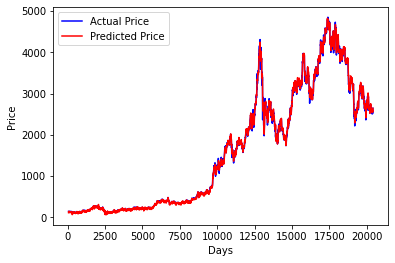

In [29]:
interactive = plot_graph(final_df)

In [ ]:

%load_ext tensorboard
%tensorboard --logdir logs